----------------------------------------------------------------------------------------------------------
***********************************************************************************************************

# <span style="color:Purple"> Computer vision for machine learning Project: "Detecting hand gestures"


#### Task 7: 

#### Author: Lynda Attouche
#### Link: https://colab.research.google.com/drive/1srDMYqq6xxHhcrpn_lsei6mYWuKxRgTW?usp=sharing
*******************************************************************************************
----------------------------------------------------------------------------------------------------------


## README
* Throughout this notebook, no special commands are needed to run the code. Simply run the cells in order. 
* In this notebook, the word *unvaried* refers to the dataset that contains no variation on the letter 'K', and varied refers to the dataset with variability on all letters.

## Importing libraries

In [1]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Dropout
import seaborn as sn
from google.colab.output import eval_js
from keras.models import model_from_json
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score
import io
import cv2
import time
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The goal of this task is to build models and train them on the different datasets generated in the previous task (dataset1: which is balanced and varied, dataset2: unbalanced and varied, dataset3: unbalanced and unvaried), which means that we will have 3 models for each dataset. These models will be saved to be used in the next task. Also, a comparison of the 3 will be carried out in this notebook.

## Loading Datasets

In [3]:
dataset_path1 = "/content/drive/MyDrive/ComputerVision/HandGesture_1/" #balanced + variation 
dataset_path2 = "/content/drive/MyDrive/ComputerVision/HandGesture_2/" #unbalanced + variation 
dataset_path3 = "/content/drive/MyDrive/ComputerVision/HandGesture_3/"  #balanced + No variation in a class
path = "/content/drive/MyDrive/ComputerVision/"

In [4]:
def load_dataset(dataset_file_path):
  """
    Loads dataset from text file 
    @param:
          dataset_file_path (string): dataset path
    @return: 
          samples (array): images
          letter (array): labels
  """
  a = np.loadtxt(dataset_file_path, delimiter=',', converters={ 0 : lambda ch : ord(ch)-ord('A') })
  samples, letters = a[:,1:], a[:,0]
  return samples, letters

In [5]:
samples1,letters1 = load_dataset(path+'/dataset1.txt')
samples2,letters2 = load_dataset(path+'/dataset2.txt')
samples3,letters3 = load_dataset(path+'/dataset3.txt')

In [6]:
def relabelling(letters):
  """
    Rellabeling images
    @params:
          - letters (array): labels
    @return:
          relabled letters
  """
  u = np.unique(letters)
  for i in range(len(letters)):
    if letters[i] ==  u[0]: 
      letters[i] = 0 #A
    elif letters[i] == u[1]:
      letters[i] = 1 #E
    elif letters[i] == u[3]:
      letters[i] = 2 #K
    else:
      letters[i] = 3  #Y
  return letters

In [7]:
#relabelling: this is done on prupose. It allows simplification
letters1 = relabelling(letters1)
letters2 = relabelling(letters2)
letters3 = relabelling(letters3)

## Data preprocessing

In [8]:
def split(train_ratio, samples, letters):
  """
  Splits data in train and validation set
  @params:
      train_ratio (float): proportion of the train set
      samples (array): images
      letters (array): labels
  @return: 
      x_train,y_train: images and labels of training set
      x_val,y_val: images and labels of validation set
  """
  n_train_samples = int(len(samples) * train_ratio)
  x_train, y_train = samples[:n_train_samples], letters[:n_train_samples]
  x_val, y_val = samples[n_train_samples:], letters[n_train_samples:]
  return x_train,y_train,x_val,y_val

In [9]:
#splitting
train_ratio = 0.7  #here 70% of the data will be the trainset and 30% the validation one
x_train1,y_train1,x_val1,y_val1 = split(train_ratio, samples1, letters1)
x_train2,y_train2,x_val2,y_val2 = split(train_ratio, samples2, letters2)
x_train3,y_train3,x_val3,y_val3 = split(train_ratio, samples3, letters3)

In [10]:
def prepro(num_classes,x_train,y_train,x_val,y_val):
  """
    Normalizes data and converts labels to binary class matrices
    @params:
          num_classes(int): number of classes in the dataset
          x_train (array): images of train set
          y_train (array): labels of train set (0,1,2,3)
          x_val (array): images of train set
          y_val (array): labels of train set (0,1,2,3)
    @return: 
          x_train : normalized train images
          y_train: converted train labels
          x_val : normalized validation images
          y_val: converted validation labels
  """
  x_train = x_train.astype('float32')
  x_val = x_val.astype('float32')
  # we normalize data (convert value to range from 0 to 1)
  # this is done to reduce computation complexity (because origin values are high and thus it's more complex)
  # by this reduction, the computation will be faster and easier
  x_train /= 255
  x_val /= 255
  # convert class vectors to binary class matrices
  # converting them is required to train our models
  y_train = tf.keras.utils.to_categorical(y_train, num_classes)
  y_val = tf.keras.utils.to_categorical(y_val, num_classes)
  return x_train,y_train,x_val,y_val

In [11]:
num_classes = 4 #number of classes 
#preprocessing the data
x_train1,y_train1,x_val1,y_val1 = prepro(num_classes,x_train1,y_train1,x_val1,y_val1)
x_train2,y_train2,x_val2,y_val2 = prepro(num_classes,x_train2,y_train2,x_val2,y_val2)
x_train3,y_train3,x_val3,y_val3 = prepro(num_classes,x_train3,y_train3,x_val3,y_val3)

### Building, training, evaluating models

In [12]:
def plot_acc_loss(str,history):
    """
    Plot accuracy and loss of a model
    @params:
            - history: history of the model
    @return:
            plots
    """
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(str, fontsize=16)

    l = list(history.history.keys())
    print(l)
    # accuracy plot
    ax[0].plot(history.history[l[1]])
    ax[0].plot(history.history[l[3]])
    ax[0].set_title('Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Valid'], loc='upper left')

    # loss plot
    ax[1].plot(history.history[l[0]])
    ax[1].plot(history.history[l[2]])
    ax[1].set_title('Loss') 
    ax[1].set_ylabel('Loss') 
    ax[1].set_xlabel('Epoch') 
    ax[1].legend(['Train', 'Valid'], loc='upper left') 
    plt.show()

In [13]:
epochs = 20 #number of epochs for training

### Model 1: using dataset 1

In [14]:
model1 = Sequential() #sequential network
model1.add(Dense(200, activation='relu', input_shape=(256,))) #first hidden layer with 200 neurons, it takes input of shape (256,), which is the shape of our images in the text file
#we use relu activation function to avoid gradient vanishing
model1.add(Dropout(0.5)) #dropout layer with proba 0.4
model1.add(Dense(100, activation='relu'))  #second dense layer with 100 neurons
model1.add(Dense(num_classes, activation='softmax')) #output layer: number_classes (4) and we use the activation function softmax because we have a multiclassification problem

model1.summary() #print a summary of the neural network

model1.compile(loss='categorical_crossentropy', #we use categorical cross entrpy as loss function since we have many classes 
              optimizer='adam', #as an optimizer Adam is used to speed up computations 
              metrics=['accuracy']) #as metric we use accuracy (proportion of true results among all the predictions)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               51400     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 71,904
Trainable params: 71,904
Non-trainable params: 0
_________________________________________________________________


In [15]:
#as an optimization technique, early stopping is used with respect to accuracy, it will help us to stop the training before it overfits 
callback = tf.keras.callbacks.EarlyStopping(patience=4) 
#training model on the train set
history1 = model1.fit(x_train1, y_train1,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val1, y_val1),
                    callbacks=[callback])
#evaluating the model using validation set
score1 = model1.evaluate(x_val1, y_val1, verbose=0)
print('Validation loss for balanced and varied dataset:', score1[0])
print('Validation accuracy for balanced and varied dataset:', score1[1])

Epoch 1/20
15/15 [==============================] - 2s 48ms/step - loss: 1.4123 - accuracy: 0.2979 - val_loss: 1.2330 - val_accuracy: 0.4703
Epoch 2/20
15/15 [==============================] - 0s 14ms/step - loss: 1.1808 - accuracy: 0.4979 - val_loss: 1.0633 - val_accuracy: 0.6584
Epoch 3/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0268 - accuracy: 0.5936 - val_loss: 0.9328 - val_accuracy: 0.6832
Epoch 4/20
15/15 [==============================] - 0s 17ms/step - loss: 0.8980 - accuracy: 0.6426 - val_loss: 0.8179 - val_accuracy: 0.7228
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 0.7743 - accuracy: 0.7149 - val_loss: 0.7346 - val_accuracy: 0.7525
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 0.6652 - accuracy: 0.7702 - val_loss: 0.7038 - val_accuracy: 0.7228
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 0.5680 - accuracy: 0.7957 - val_loss: 0.6508 - val_accuracy: 0.7673
Epoch 8/20
15/

['loss', 'accuracy', 'val_loss', 'val_accuracy']


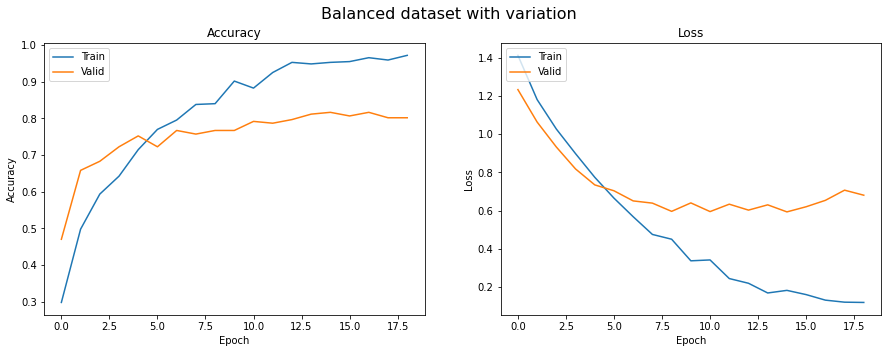

In [16]:
plot_acc_loss('Balanced dataset with variation',history1) #plotting accuracy and loss function

###### Comment:
It can be seen that the two curves: accuracy and loss are not smooth enough. Moreover, the loss does not reach zero and rubs the overfitting. 

### Model 2: using dataset 2

In [17]:
model2 = Sequential() #sequential network
model2.add(Dense(100, activation='relu', input_shape=(256,))) #first hidden layer with 100 neurons, it takes input of shape (256,), which is the shape of our images in the text file
#we use relu activation function to avoid gradient vanishing
model2.add(Dropout(0.4)) #dropout layer with proba 0.4
model2.add(Dense(50, activation='relu')) #second dense layer with 50 neurons
model2.add(Dense(num_classes, activation='softmax')) #output layer: number_classes (4) and we use the activation function softmax because we have a multiclassification problem

model2.summary() #print a summary of the neural network

model2.compile(loss='categorical_crossentropy', #we use categorical cross entrpy as loss function since we have many classes 
              optimizer='adam', #as an optimizer Adam is used to speed up computations 
              metrics=['accuracy']) #as metric we use accuracy (proportion of true results among all the predictions)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               25700     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 4)                 204       
                                                                 
Total params: 30,954
Trainable params: 30,954
Non-trainable params: 0
_________________________________________________________________


In [18]:
#as an optimization technique, early stopping is used with respect to accuracy, it will help us to stop the training before it overfits 
callback = tf.keras.callbacks.EarlyStopping(patience=3)  #lower value because it is more sensitive to overfitting
#training model on the train set
history2 = model2.fit(x_train2, y_train2,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val2, y_val2),
                    callbacks=[callback])
#evaluating the model using validation set
score2 = model2.evaluate(x_val2, y_val2, verbose=0)
print('Validation loss for unbalanced and varied dataset:', score2[0])
print('Validation accuracy for unbalanced and varied dataset:', score2[1])

Epoch 1/20
10/10 [==============================] - 1s 54ms/step - loss: 1.3552 - accuracy: 0.3299 - val_loss: 1.2259 - val_accuracy: 0.4173
Epoch 2/20
10/10 [==============================] - 0s 17ms/step - loss: 1.1535 - accuracy: 0.4932 - val_loss: 1.1527 - val_accuracy: 0.4646
Epoch 3/20
10/10 [==============================] - 0s 18ms/step - loss: 1.1051 - accuracy: 0.5204 - val_loss: 1.0711 - val_accuracy: 0.5906
Epoch 4/20
10/10 [==============================] - 0s 23ms/step - loss: 0.9886 - accuracy: 0.6020 - val_loss: 0.9935 - val_accuracy: 0.6535
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 0.9141 - accuracy: 0.6395 - val_loss: 0.9059 - val_accuracy: 0.6772
Epoch 6/20
10/10 [==============================] - 0s 14ms/step - loss: 0.7854 - accuracy: 0.6633 - val_loss: 0.8451 - val_accuracy: 0.6693
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 0.7761 - accuracy: 0.6735 - val_loss: 0.8017 - val_accuracy: 0.6772
Epoch 8/20
10

['loss', 'accuracy', 'val_loss', 'val_accuracy']


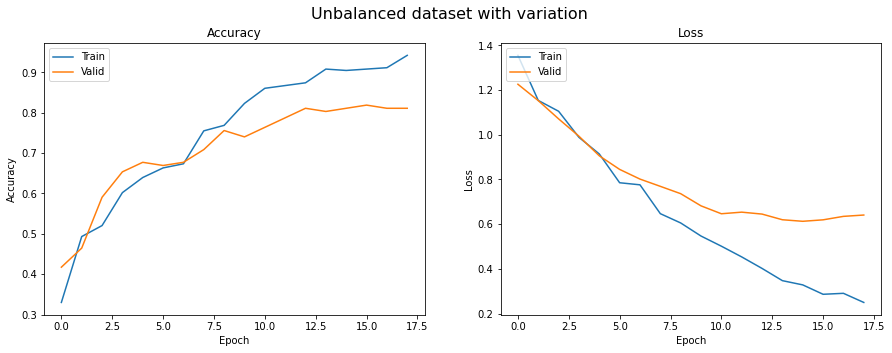

In [19]:
plot_acc_loss('Unbalanced dataset with variation',history2) #plotting accuracy and loss function

###### Comment:
For this new dataset/model, the look of the curves is similar to the one before. However, here the overfitting is more obvious. 

### Model 3: using dataset 3

In [20]:
model3 = Sequential() #sequential network
model3.add(Dense(100, activation='relu', input_shape=(256,))) #first hidden layer with 100 neurons, it takes input of shape (256,), which is the shape of our images in the text file
#we use relu activation function to avoid gradient vanishing
model3.add(Dropout(0.4)) #dropout layer with proba 0.5
model3.add(Dense(50, activation='relu')) #second dense layer with 50 neurons
model3.add(Dropout(0.4)) #dropout layer with proba 0.5
model3.add(Dense(num_classes, activation='softmax')) #output layer: number_classes (4) and we use the activation function softmax because we have a multiclassification problem

model3.summary() #print a summary of the neural network

model3.compile(loss='categorical_crossentropy', #we use categorical cross entrpy as loss function since we have many classes 
              optimizer='adam', #as an optimizer Adam is used to speed up computations 
              metrics=['accuracy']) #as metric we use accuracy (proportion of true results among all the predictions)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               25700     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 204       
                                                                 
Total params: 30,954
Trainable params: 30,954
Non-trainable params: 0
_________________________________________________________________


In [21]:
callback = tf.keras.callbacks.EarlyStopping(patience=2)  #lower value because it is more sensitive to overfitting
#training model on the train set
history3 = model3.fit(x_train3, y_train3,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val3, y_val3),
                    callbacks=[callback])
#evaluating the model using validation set
score3 = model3.evaluate(x_val3, y_val3, verbose=0)
print('Validation loss for unbalanced and unvaried dataset:', score3[0])
print('Validation accuracy for unbalanced and unvaried dataset:', score3[1])

Epoch 1/20
15/15 [==============================] - 1s 34ms/step - loss: 1.4243 - accuracy: 0.3319 - val_loss: 1.1227 - val_accuracy: 0.6139
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0771 - accuracy: 0.5553 - val_loss: 0.9099 - val_accuracy: 0.6931
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 0.8828 - accuracy: 0.6447 - val_loss: 0.7200 - val_accuracy: 0.7079
Epoch 4/20
15/15 [==============================] - 0s 16ms/step - loss: 0.7632 - accuracy: 0.6894 - val_loss: 0.6164 - val_accuracy: 0.7475
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 0.6872 - accuracy: 0.7043 - val_loss: 0.5761 - val_accuracy: 0.7574
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 0.6107 - accuracy: 0.7277 - val_loss: 0.5646 - val_accuracy: 0.7673
Epoch 7/20
15/15 [==============================] - 0s 14ms/step - loss: 0.5144 - accuracy: 0.7957 - val_loss: 0.5256 - val_accuracy: 0.7871
Epoch 8/20
15/1

['loss', 'accuracy', 'val_loss', 'val_accuracy']


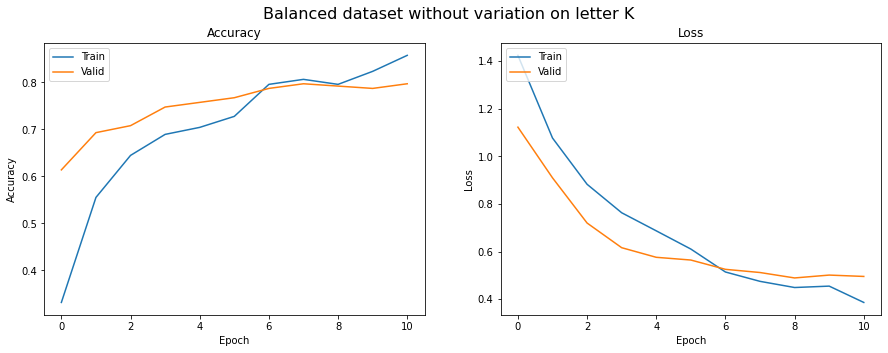

In [22]:
plot_acc_loss('Balanced dataset without variation on letter K',history3) #plotting accuracy and loss function

###### Comment:
Similarly to the previous curves, the loss curve is ot reaching 0 and an overfitting can be noticed. 

#### Note: 
The lack of higher accuracy, despite several improvements (change of the number of neurons, layers, the addition of regularizers, dropout,...etc) as well as the beginning of overfitting is due to the choice of the classes. Indeed, the 'a' and 'e' classes are very close and the images can be confusing.

## Comparing models: accuracy, loss and behavior with different datasets

To compare the models, we start with a comparison of the precisions and losses obtained previously. Then we will evaluate each of them on the other datasets (those which are not used for its evaluation) to see their behavior

#### a) Accuracy and loss

Following is a summary table of the performance of the 3 models (loss and accuracy)

In [23]:
df = pd.DataFrame({'Model_1': [round(score1[0],3),round(score1[1],3)], 
                  'Model_2': [round(score2[0],3),round(score2[1],3)],
                  'Model_3': [round(score3[0],3),round(score3[1],3)]},
                  index=['Loss','Accuracy'])
df

,Model_1,Model_2,Model_3
Loss,0.681,0.641,0.496
Accuracy,0.802,0.811,0.797


###### Comment:
The accuracy and loss are quite similar for the 3 datasets. It should be stressed that the evaluation is done on the same dataset, so the characteristics of the train set and validation are the same, which means that the comparison is not effective. This is why testing these models on new data with different properties is essential for the comparison. And this is what will be done in the next section.

#### b) With other datasets
To address the concerns of the previous question and to compare the datasets in an efficient and clear way, the models will be tested on never seen data which will be the datasets used to generate the other models. To do the analysis, we use the accuracy as a metric and analyze the confusion matrix.

##### $\rightarrow$ Model 1 with dataset 2 and 3

Accuracy for unbalanced and varied dataset with model1: 0.936




[Text(0, 0.5, 'A'), Text(0, 1.5, 'E'), Text(0, 2.5, 'K'), Text(0, 3.5, 'Y')]

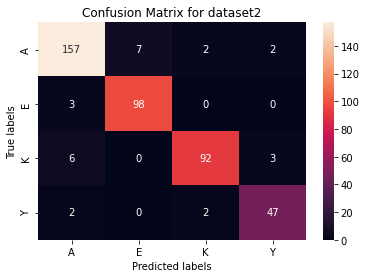

In [24]:
# DATASET 2
pred12 = model1.predict(samples2) #predict on dataset 2
pred12 = np.array(np.argmax(pred12,axis=1)) #inverse of to_categorical is computed by selecting the argmax
cm12 = confusion_matrix(letters2,pred12)  
score12 = model1.evaluate(samples2 , tf.keras.utils.to_categorical(letters2, num_classes), verbose=0) #evaluation on dataset 2
print('Accuracy for unbalanced and varied dataset with model1:', round(score12[1],3))

print('\n')
# Plotting confusion matrix
ax= plt.subplot()
sn.heatmap(cm12, annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for dataset2'); 
ax.xaxis.set_ticklabels(['A', 'E','K','Y'])
ax.yaxis.set_ticklabels(['A', 'E','K','Y'])

Accuracy for unbalanced and unvaried dataset with model1: 0.933




[Text(0, 0.5, 'A'), Text(0, 1.5, 'E'), Text(0, 2.5, 'K'), Text(0, 3.5, 'Y')]

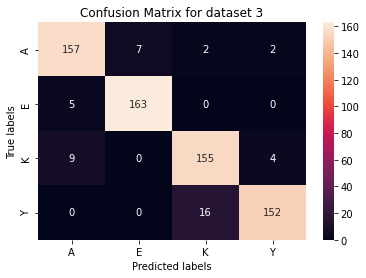

In [25]:
# DATASET 3
pred13 = model1.predict(samples3) #predict on dataset 3
pred13 = np.array(np.argmax(pred13,axis=1)) #inverse of to_categorical is computed by selecting the argmax
cm13 = confusion_matrix(letters3,pred13)  
score13 = model1.evaluate(samples3 , tf.keras.utils.to_categorical(letters3, num_classes), verbose=0) #evaluation on dataset 3
print('Accuracy for unbalanced and unvaried dataset with model1:', round(score13[1],3))

print('\n')
# Plotting confusion matrix
ax= plt.subplot()
sn.heatmap(cm13, annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for dataset 3'); 
ax.xaxis.set_ticklabels(['A', 'E','K','Y'])
ax.yaxis.set_ticklabels(['A', 'E','K','Y'])

###### Comments:

It can be seen that the first dataset reaches an accuracy of about 93% and 92% for datasets 2 and 3, respectively. This proves its efficiency in generalizing. The two confusion matrices are quite satisfactory. All letters are mostly well classified. This is since the dataset that was used to train the model contains a lot of variability in the letters, but also the fact that it is balanced helps a lot. 

##### $\rightarrow$ Model 2 with dataset 1 and 3

Accuracy for balanced and varied dataset with model2: 0.722




[Text(0, 0.5, 'A'), Text(0, 1.5, 'E'), Text(0, 2.5, 'K'), Text(0, 3.5, 'Y')]

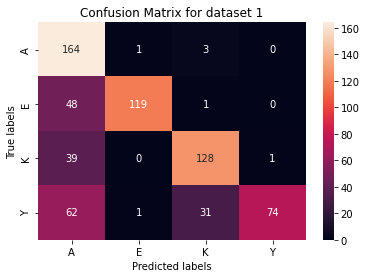

In [26]:
# DATASET 1
pred21 = model2.predict(samples1) #predict on dataset 1
pred21 = np.array(np.argmax(pred21,axis=1)) #inverse of to_categorical is computed by selecting the argmax
cm21 = confusion_matrix(letters1,pred21)  
score21 = model2.evaluate(samples1 , tf.keras.utils.to_categorical(letters1, num_classes), verbose=0) #evaluation on dataset 1
print('Accuracy for balanced and varied dataset with model2:', round(score21[1],3))

print('\n')
# Plotting confusion matrix
ax= plt.subplot()
sn.heatmap(cm21, annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for dataset 1'); 
ax.xaxis.set_ticklabels(['A', 'E','K','Y'])
ax.yaxis.set_ticklabels(['A', 'E','K','Y'])

Accuracy for balanced and unvaried dataset with model2: 0.722




[Text(0, 0.5, 'A'), Text(0, 1.5, 'E'), Text(0, 2.5, 'K'), Text(0, 3.5, 'Y')]

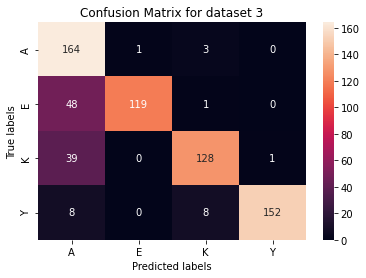

In [27]:
# DATASET 3
pred23 = model2.predict(samples3) #predict on dataset 3
pred23 = np.array(np.argmax(pred23,axis=1)) #inverse of to_categorical is computed by selecting the argmax
cm23 = confusion_matrix(letters3,pred23)  
score23 = model2.evaluate(samples1 , tf.keras.utils.to_categorical(letters1, num_classes), verbose=0) #evaluation on dataset 3
print('Accuracy for balanced and unvaried dataset with model2:', round(score23[1],3))

print('\n')
# Plotting confusion matrix
ax= plt.subplot()
sn.heatmap(cm23, annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for dataset 3'); 
ax.xaxis.set_ticklabels(['A', 'E','K','Y'])
ax.yaxis.set_ticklabels(['A', 'E','K','Y'])

###### Comments:
Note that this model has been trained with the unbalanced dataset and we remind you that the majority class is 'A' and the minority is 'K'.The performances are lower than the first model. Indeed the accuracy is about 69% and 64% which is not satisfactory.We see that the best-classified class is 'A', not surprisingly being the majority class in the training dataset. What is also interesting is that for the same reason, the model made a lot of errors in the other classes by classifying them in 'A'.

##### $\rightarrow$ Model 3 with dataset 1 and 2

Accuracy for balanced and varied dataset with model3: 0.677




[Text(0, 0.5, 'A'), Text(0, 1.5, 'E'), Text(0, 2.5, 'K'), Text(0, 3.5, 'Y')]

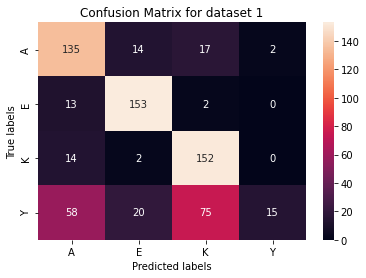

In [28]:
# DATASET 1
pred31 = model3.predict(samples1) #predict on dataset 1
pred31 = np.array(np.argmax(pred31,axis=1)) #inverse of to_categorical is computed by selecting the argmax
cm31 = confusion_matrix(letters1,pred31)  
score31 = model3.evaluate(samples1 , tf.keras.utils.to_categorical(letters1, num_classes), verbose=0) #evaluation on dataset 1
print('Accuracy for balanced and varied dataset with model3:', round(score31[1],3))

print('\n')
# Plotting confusion matrix
ax= plt.subplot()
sn.heatmap(cm31, annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for dataset 1'); 
ax.xaxis.set_ticklabels(['A', 'E','K','Y'])
ax.yaxis.set_ticklabels(['A', 'E','K','Y'])

Accuracy for unbalanced and varied dataset with model3: 0.793




[Text(0, 0.5, 'A'), Text(0, 1.5, 'E'), Text(0, 2.5, 'K'), Text(0, 3.5, 'Y')]

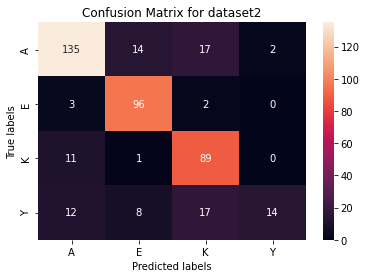

In [29]:
# DATASET 2
pred32 = model3.predict(samples2) #predict on dataset 2
pred32 = np.array(np.argmax(pred32,axis=1)) #inverse of to_categorical is computed by selecting the argmax
cm32 = confusion_matrix(letters2,pred32)  
score32 = model3.evaluate(samples2 , tf.keras.utils.to_categorical(letters2, num_classes), verbose=0) #evaluation on dataset 2
print('Accuracy for unbalanced and varied dataset with model3:', round(score32[1],3))

print('\n')
# Plotting confusion matrix
ax= plt.subplot()
sn.heatmap(cm32, annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for dataset2'); 
ax.xaxis.set_ticklabels(['A', 'E','K','Y'])
ax.yaxis.set_ticklabels(['A', 'E','K','Y'])

##### Comments:
Like the second one, the performance is not as good as the first one. The generalization remains a bit difficult. More wrong predictions have been done. Knowing that the model was trained with a dataset without variability in the K class, we expected to have this error number.

##### Conclusion:
If we had to choose a dataset, obviously, we choose the first one because it is the one that allows us to generalize the most and to make better predictions. (the most efficient).

## Saving models and weights

In [30]:
#model 1
model_json1 = model1.to_json()
with open(path+"/"+"model1.json", "w") as json_file:
     json_file.write(model_json1)
model1.save_weights(path+"/"+"model1_weights.h5")
print("Saved model 1 to disk")

Saved model 1 to disk


In [31]:
#model 2
model_json2 = model2.to_json()
with open(path+"/"+"model2.json", "w") as json_file:
     json_file.write(model_json2)
model2.save_weights(path+"/"+"model2_weights.h5")
print("Saved model 2 to disk")

Saved model 2 to disk


In [32]:
#model 3
model_json3 = model3.to_json()
with open(path+"/"+"model3.json", "w") as json_file:
     json_file.write(model_json3)
model3.save_weights(path+"/"+"model3_weights.h5")
print("Saved model 3 to disk")

Saved model 3 to disk
